In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models, transforms

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

from skimage.exposure import rescale_intensity

from tqdm import tqdm
from metrics import SSIM

In [0]:
from MotionBlurDataset import MotionBlurDataset
from model import HDRPointwiseNN
from metrics import psnr
from PerceptualLoss import PerceptualLoss

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train

In [0]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
params = {"luma_bins":8, "channel_multiplier":1, "spatial_bin":128, "batch_norm":True, "net_input_size":256,
          "net_output_size":320, "guide_complexity":16, "coeff_num":56, "use_residual":True}

In [6]:
#dataset = GoProDataset("drive/My Drive/EECS 225B/gopro")
dataset = MotionBlurDataset("drive/My Drive/EECS 225B/data/train")
model = HDRPointwiseNN(params=params)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-8)
percep = PerceptualLoss(device=DEVICE)
ssim = SSIM()
mse = nn.MSELoss()

5


Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [0]:
model = model.to(DEVICE)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, drop_last=False)

In [0]:
def train(num_epochs, model, optimizer, data_loader):
  train_losses = []
  train_psnr = []
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    losses = []
    ssims = []
    for batch_idx, (lr, hr, target) in tqdm(enumerate(data_loader)):
      model.train()
      lr = lr.to(DEVICE)
      hr = hr.to(DEVICE)
      target = target.to(DEVICE)

      optimizer.zero_grad()

      preds = model(lr, hr)

      #loss = mse(preds, target)
      this_ssim = ssim(preds, target)
      #loss = (1 - this_ssim) 
      loss = percep(preds, target)
      loss.backward()
      losses.append(loss.item())
      ssims.append(this_ssim.item())

      optimizer.step()
      if (batch_idx + 1) % 10 == 0:
        model_psnr = psnr(target, preds).item()
        print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}\t SSIM: {:.6f}\t PSNR: {:.6f}\n'.format(epoch, 
                                                                    batch_idx * len(lr), 
                                                                    len(data_loader.dataset), 
                                                                    100. * batch_idx / len(data_loader),
                                                                    np.mean(losses),
                                                                    np.mean(ssims),
                                                                    model_psnr))
        train_psnr.append(model_psnr)
        train_losses.append(np.mean(losses))
        losses = []
        ssims = []
    torch.save(model.state_dict(), 'model.pth')
    torch.save(optimizer.state_dict(), 'optimizer.pth')
  return train_losses, train_psnr

In [0]:
losses = []
psnrs = []

In [13]:
new_losses, new_psnrs = train(30, model, optimizer, train_loader)
losses += new_losses
psnrs += new_psnrs

10it [00:07,  1.26it/s]

Train Epoch: 20 [144/948 (15%)] Loss: 1.490059	 SSIM: 0.572056	 PSNR: 17.601002



20it [00:15,  1.25it/s]

Train Epoch: 20 [304/948 (32%)] Loss: 1.569383	 SSIM: 0.545494	 PSNR: 17.254253



21it [00:16,  1.25it/s]

KeyboardInterrupt: ignored

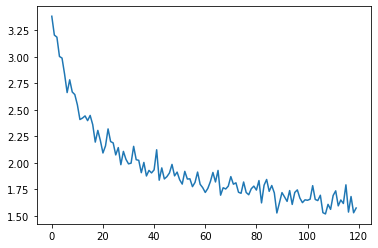

In [14]:
plt.plot(losses)

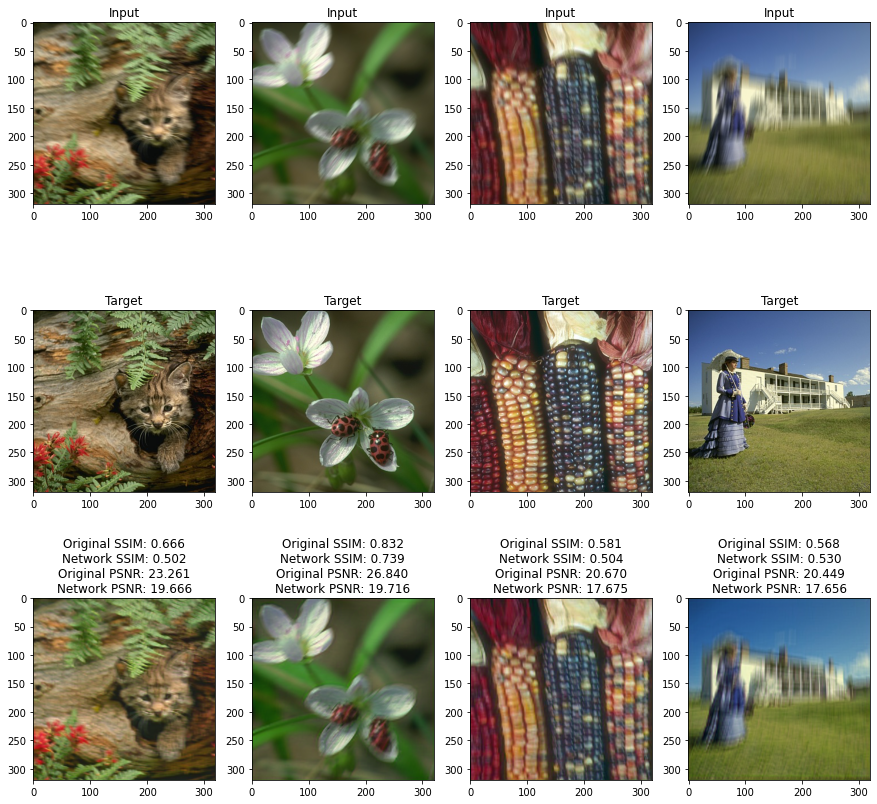

In [16]:
model.eval()
lr, hr, target = next(iter(train_loader))
lr = lr.to(DEVICE)
hr = hr.to(DEVICE)
target = target.to(DEVICE)

plt.figure(figsize=(15, 15))
with torch.no_grad():
    preds = model(lr, hr)
    outputs = preds.cpu().detach().numpy()[:4]
    outputs[outputs < 0] = 0
    outputs[outputs > 1] = 1
    for i in range(len(outputs)):
        plt.subplot(3, 4, 1 + i)
        hr_img = np.transpose(hr[i].cpu(), (1, 2, 0)).numpy()
        plt.imshow(hr_img)
        plt.title("Input")
        
        plt.subplot(3, 4, 5 + i)
        target_img = np.transpose(target[i].cpu(), (1, 2, 0)).numpy()
        plt.imshow(target_img)
        plt.title("Target")
        
        plt.subplot(3, 4, 9 + i)
        img = np.transpose(outputs[i], (1, 2, 0)).astype('float')
        plt.imshow(rescale_intensity(img, out_range=(0, 255)).astype(np.uint8))

        ssim_orig = ssim(hr[i].unsqueeze(0), target[i].unsqueeze(0)).item()
        ssim_model = ssim(preds[i].unsqueeze(0), target[i].unsqueeze(0)).item()
        psnr_orig = psnr(hr[i].unsqueeze(0), target[i].unsqueeze(0)).item()
        psnr_model = psnr(preds[i].unsqueeze(0), target[i].unsqueeze(0)).item()
        plt.title("Original SSIM: {:.3f}\nNetwork SSIM: {:.3f}\nOriginal PSNR: {:.3f}\nNetwork PSNR: {:.3f}".format(ssim_orig, 
                                                                        ssim_model,
                                                                        psnr_orig,
                                                                        psnr_model))
        
plt.show()

# Test

In [0]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
params = {"luma_bins":8, "channel_multiplier":1, "spatial_bin":128, "batch_norm":True, "net_input_size":256,
          "net_output_size":320, "guide_complexity":16}
#params = {"luma_bins":8, "channel_multiplier":1, "spatial_bin":16, "batch_norm":True, "net_input_size":256,
#          "net_output_size":320, "guide_complexity":16, }

In [23]:
model = HDRPointwiseNN(params=params)
ssim = SSIM()

5


In [0]:
state_dict = torch.load('model.pth')
model.load_state_dict(state_dict)
model = model.eval()
model = model.to(DEVICE)

In [25]:
test_set = MotionBlurDataset("drive/My Drive/EECS 225B/data/test", augmentation_transforms=None)
print(len(test_set))

219


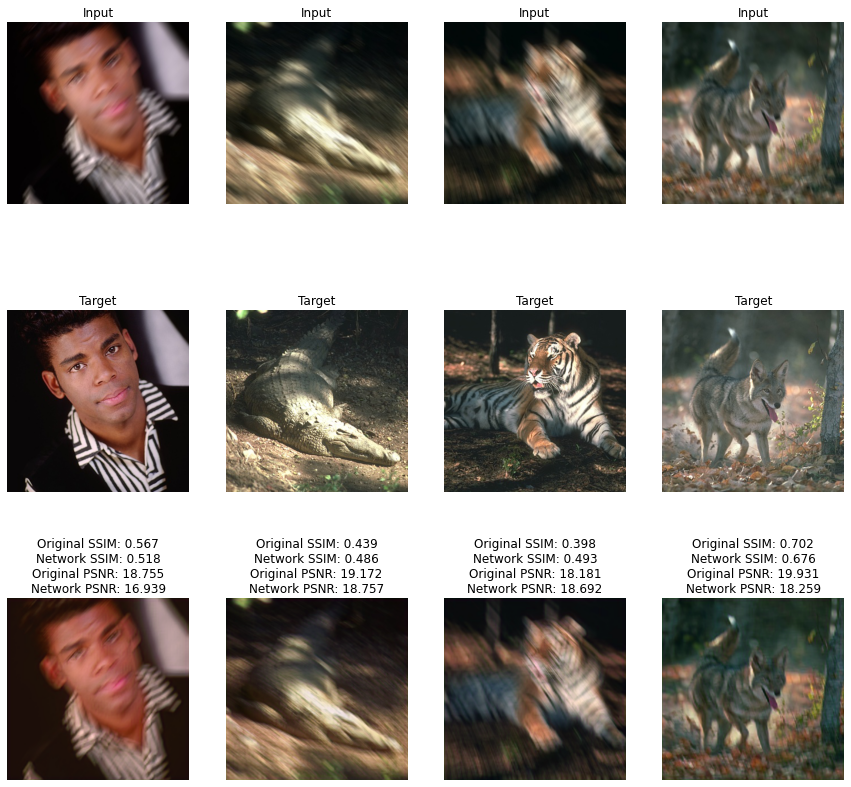

In [26]:
model.eval()
lr, hr, target = [], [], []
for i in [166, 68, 72, 66]:
  lr_i, hr_i, target_i = test_set[i]
  lr.append(lr_i)
  hr.append(hr_i)
  target.append(target_i)
  
lr = torch.stack(lr)
hr = torch.stack(hr)
target = torch.stack(target)

lr = lr.to(DEVICE)
hr = hr.to(DEVICE)
target = target.to(DEVICE)

plt.figure(figsize=(15, 15))
with torch.no_grad():
    preds = model(lr, hr)
    outputs = preds.cpu().detach().numpy()[:4]
    outputs[outputs < 0] = 0
    outputs[outputs > 1] = 1
    for i in range(len(outputs)):
        plt.subplot(3, 4, 1 + i)
        hr_img = np.transpose(hr[i].cpu(), (1, 2, 0)).numpy()
        plt.imshow(hr_img)
        plt.title("Input")
        plt.axis('off')
        
        plt.subplot(3, 4, 5 + i)
        target_img = np.transpose(target[i].cpu(), (1, 2, 0)).numpy()
        plt.imshow(target_img)
        plt.title("Target")
        plt.axis('off')
        
        plt.subplot(3, 4, 9 + i)
        img = np.transpose(outputs[i], (1, 2, 0)).astype('float')
        plt.imshow(rescale_intensity(img, out_range=(0, 255)).astype(np.uint8))
        plt.axis('off')

        ssim_orig = ssim(hr[i].unsqueeze(0), target[i].unsqueeze(0)).item()
        ssim_model = ssim(preds[i].unsqueeze(0), target[i].unsqueeze(0)).item()
        psnr_orig = psnr(hr[i].unsqueeze(0), target[i].unsqueeze(0)).item()
        psnr_model = psnr(preds[i].unsqueeze(0), target[i].unsqueeze(0)).item()
        plt.title("Original SSIM: {:.3f}\nNetwork SSIM: {:.3f}\nOriginal PSNR: {:.3f}\nNetwork PSNR: {:.3f}".format(ssim_orig, 
                                                                        ssim_model,
                                                                        psnr_orig,
                                                                        psnr_model))
        
plt.show()